<a href="https://colab.research.google.com/github/rogermasclans/measuring_the_commercial_potential_of_science/blob/main/science_compot_montecarlo_dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Measuring The Commercial Potential of Science 
## Masclans, R., Hasan, S., and Cohen, W. 2024
## Monte Carlo Drop Out Simulation
This notebook contains the code to run a Monte Carlo Drop Out Simulation to quantify the models' uncertainty ....



In [1]:
# Install transformers setup 
!pip install -q -U watermark
!pip install -qq transformers # installs transformers library
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, AutoTokenizer, AutoModel #Automodel, Autotokenizer for SciBert
import torch
from torch import nn, optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
import gc


import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils import shuffle
from collections import defaultdict
from textwrap import wrap
from google.cloud import storage
import subprocess
import time
from datetime import datetime
import pytz
et_timezone = pytz.timezone('US/Eastern')
import sys



Python implementation: CPython
Python version       : 3.7.12
IPython version      : 7.34.0

numpy       : 1.21.6
pandas      : 1.3.5
torch       : 1.13.0
transformers: 4.30.2



In [2]:
import pandas as pd
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from google.cloud import bigquery
import numpy as np


In [7]:
# Set Working Directory
# os.chdir('../')

os.chdir('/home/jupyter')
print(os.getcwd())


/home/jupyter


In [ ]:
# Download Models to local environment
!gsutil -m cp -r  gs://models-sci-comm/v2 v2

In [4]:
# Set model Params

MAX_LEN = 512
TEST_SIZE = 0.25 

epochs = 5
drop_out_rate = 0.3 # baseline == 0.3
lr = 2e-5 
model_used = 'scibert' #specter2_base
training_data_folder = 'training-data'
batch_size = 32 # baseline == 16

rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)



In [ ]:
# Get Monte Carlo Drop Out Predictions, by year


# Initalize dataframe to store predictions
df_inf_sample = pd.DataFrame(columns=[
    "pub_id",
    "abstract_inferred", 
    "year",
    "class_compot", 
    "prob_low_compot", 
    "prob_high_compot", 
    "std_low_compot", 
    "std_high_compot"
])

for year in range(2000, 2021):

    pred_year = year
    print('----------------------------------------------------------------')
    print('Year = ', pred_year)
    print('----------------------------------------------------------------')

    ########################################################################################################################################################################################################################################################################
    # LOAD MODEL
    ########################################################################################################################################################################################################################################################################


    torch.cuda.empty_cache()
    gc.collect()
    model_location = f'v2/models/compot_model_{pred_year}.bin'
    print('current model:', model_location)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    pre_trained_model_name = 'scibert_scivocab_uncased'
    print(f"Using {pre_trained_model_name} model.")
    
    
    print('Loading tokenizer and model...')
    tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')


    class SentimentClassifier(nn.Module):

        def __init__(self, n_classes):
          super(SentimentClassifier, self).__init__()
          self.bert = AutoModel.from_pretrained('allenai/scibert_scivocab_uncased', return_dict=False)
          self.drop = nn.Dropout(p=0)
          self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

        def forward(self, input_ids, attention_mask):
          _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
          )
          output = self.drop(pooled_output)
          return self.out(output)

    model = SentimentClassifier(2)
    model.load_state_dict(torch.load(model_location, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')), strict=False) # set the strict argument to False in the load_state_dict() function to ignore non-matching keys:
    model.eval()  
    model = model.to(device)
    print(f'model {model_location} successfully loaded')



    ########################################################################################################################################################################################################################################################################
    # LOAD DATA FROM BQ
    ########################################################################################################################################################################################################################################################################

    print(f'downloading GBQ data for {model_location}, year {pred_year}...')

    # Set GCP project and BigQuery table details
    project_id = 'xxx'
    dataset_id = 'xxx'
    table_id = 'xxx'
    
    # Authenticate to Google Cloud
    client = bigquery.Client(project=project_id)

    # Set allow_large_results to True
    job_config = bigquery.QueryJobConfig()
    job_config.allow_large_results = True

    # Construct the SQL query to fetch data from BigQuery
    query = f'''
    SELECT 
        id as pub_id, abstract.preferred as abstract 
    FROM `{project_id}.{dataset_id}.{table_id}` 
    WHERE year = {prediction_year} AND id IN (SELECT pub_id FROM `{project_id}.{dataset_id}.pub_org` WHERE country_code = "US")
    '''

    # Fetch data from BigQuery
    query_job = client.query(query, job_config=job_config)
    results = query_job.result()  # Waits for the query to complete

    # Convert the result to a pandas DataFrame
    df = results.to_dataframe()

    seed = 1234
    df = df.sample(n=5000, random_state=seed).reset_index(drop=True)

    print(f'{model_location} data successfully downloaded from GBQ')

    # Print the first few rows of the DataFrame
    print(df)



    ########################################################################################################################################################################################################################################################################
    # GET PREDICTIONS, MONTECARLO DROPOUT SIMULATION
    ########################################################################################################################################################################################################################################################################


    # Number of Monte Carlo samples
    MC_SAMPLES = 10

    i = 0
    print('Predicting with MC dropout...     Start time: ', datetime.fromtimestamp(time.time(), tz=pytz.utc).astimezone(et_timezone).strftime('%H:%M:%S'))

    for abstract in df["abstract"]:
        try:
            encoded_review = tokenizer.encode_plus(
                abstract,
                max_length=MAX_LEN,
                add_special_tokens=True,
                return_token_type_ids=False,
                pad_to_max_length=True,
                return_attention_mask=True,
                return_tensors='pt',
            )

            input_ids = encoded_review['input_ids']
            attention_mask = encoded_review['attention_mask']

            # Enable dropout
            model.train()

            # Initialize tensors to store MC samples
            probs_mc = torch.zeros(MC_SAMPLES, 2)  # binary classification 

            for mc_sample in range(MC_SAMPLES):
                with torch.no_grad():
                    output = model(input_ids.to(device), attention_mask.to(device))
                    probs_mc[mc_sample] = F.softmax(output, dim=1)

                    # print(f'mc_sample:\n{mc_sample}')


            # Calculate mean and standard deviation across MC samples
            mean_probs = probs_mc.mean(0)
            std_probs = probs_mc.std(0)

            # Extract prediction based on the mean probability
            _, prediction = torch.max(mean_probs, dim=0)

         # Create a new DataFrame for the new row
            new_row = {
                "pub_id": df["pub_id"][i],
                "abstract_inferred": abstract,
                "year": pred_year,
                "class_compot": prediction.cpu().item(),
                "prob_low_compot": mean_probs.cpu().numpy()[0],
                "prob_high_compot": mean_probs.cpu().numpy()[1],
                "std_low_compot": std_probs.cpu().numpy()[0],  # Uncertainty measure
                "std_high_compot": std_probs.cpu().numpy()[1]  # Uncertainty measure

            }

            # Append the new row to the existing DataFrame
            df_inf_sample = df_inf_sample.append(new_row, ignore_index=True)
            
            i += 1
            # print(i)
            
        except Exception as error:
            print("Error processing abstract at index", i, ":", error)
    
            # Create a new DataFrame for the new row
            new_row = {
                "pub_id": df["pub_id"][i],
                "abstract_inferred": abstract,
                "year": pred_year,
                "class_compot": np.nan,
                "prob_low_compot": np.nan,
                "prob_high_compot": np.nan,
                "std_low_compot": np.nan,
                "std_high_compot": np.nan
            }

            # Append the new row to the existing DataFrame
            df_inf_sample = df_inf_sample.append(new_row, ignore_index=True)
            
            i += 1
            
    print('MC Dropout predictions finished. Finish time: ', datetime.fromtimestamp(time.time(), tz=pytz.utc).astimezone(et_timezone).strftime('%H:%M:%S'))    
    print(df_inf_sample)
    df_inf_sample.to_csv('v2/df_inf_sample.csv')
   
    # Remove current model from memory
    print('Removing current model from memory...')
    del model
    gc.collect()
    torch.cuda.empty_cache()  # For GPU

# Analysis

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


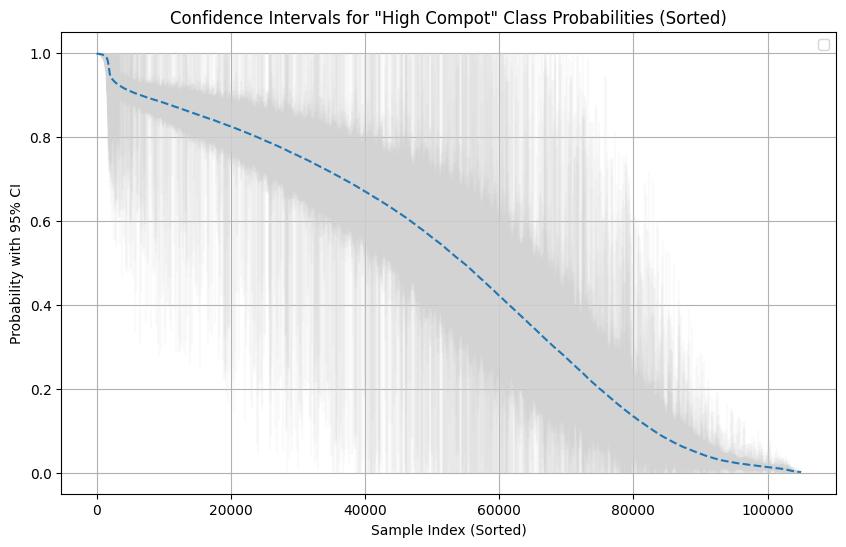

In [16]:


# Assuming df_inf_sample is already defined and contains the relevant columns

# Sort the DataFrame in descending order by 'prob_high_compot'
df_sorted = df_inf_sample.sort_values(by='prob_high_compot', ascending=False).reset_index(drop=True)

# Extract the sorted columns to numpy arrays for easier handling
sorted_prob_high_compot = df_sorted["prob_high_compot"].to_numpy(dtype=float)
sorted_std_high_compot = df_sorted["std_high_compot"].to_numpy(dtype=float)
indices = np.arange(len(sorted_prob_high_compot))  # Indices after sorting

# Calculate the 95% confidence intervals
z_score = 1.96  # Z-score for 95% confidence
sorted_conf_intervals = z_score * sorted_std_high_compot

# Adjust the confidence intervals for truncation at 0 and 1
lower_bounds = np.maximum(sorted_prob_high_compot - sorted_conf_intervals, 0)
upper_bounds = np.minimum(sorted_prob_high_compot + sorted_conf_intervals, 1)

# Plotting
plt.figure(figsize=(10, 6))

# Plot the error bars with transparency
plt.errorbar(indices, sorted_prob_high_compot, yerr=[sorted_prob_high_compot - lower_bounds, upper_bounds - sorted_prob_high_compot], fmt='none', ecolor='lightgrey', alpha=0.1, capthick=1)

# Plot the mean markers
plt.plot(indices, sorted_prob_high_compot, '--')

plt.title('Confidence Intervals for "High Compot" Class Probabilities (Sorted)')
plt.xlabel('Sample Index (Sorted)')
plt.ylabel('Probability with 95% CI')
plt.legend()
plt.grid(True)
plt.show()